Load packages

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd

In [8]:
# Load dataset
data = pd.read_csv("train_languages.csv")

# Encode labels to numerical format
label_mapping = {lang: idx for idx, lang in enumerate(data['language'].unique())}
data['label'] = data['language'].map(label_mapping)

# Split data into training and testing
train_texts, test_texts, train_labels, test_labels = train_test_split(data['sentence'].tolist(), data['label'].tolist(), test_size=0.1, random_state=42)

In [9]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(type(train_texts))  # Should be a list
print(train_texts[:1])    # Check first few items to ensure they are strings


<class 'list'>
["Le Ménil-Vicomte est une commune française, située dans le département de l'Orne en région Normandie, peuplée de 29 habitants."]


In [11]:
sample_encoding = tokenizer(train_texts[0], truncation=True, padding=True, max_length=128)
print(sample_encoding)


{'input_ids': [101, 10281, 150, 75043, 10161, 118, 39574, 10692, 10216, 10176, 10231, 11380, 14202, 117, 15366, 10260, 10141, 16236, 10104, 180, 112, 59934, 10110, 14387, 25771, 117, 14574, 55852, 11245, 10104, 10386, 12198, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
class LanguageDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)  # Ensure labels are tensors

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # No additional tensor conversion
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


In [13]:
print(type(train_labels), type(train_labels[0]))  # Should be list, int


<class 'list'> <class 'int'>


In [15]:
# Check types and lengths of your datasets
print(f"train_texts type: {type(train_texts)}, length: {len(train_texts)}")
print(f"train_labels type: {type(train_labels)}, length: {len(train_labels)}")
print(f"test_texts type: {type(test_texts)}, length: {len(test_texts)}")
print(f"test_labels type: {type(test_labels)}, length: {len(test_labels)}")

# Check if labels are all integers
print(f"Sample train_labels: {train_labels[:5]}")


train_texts type: <class 'list'>, length: 3269
train_labels type: <class 'list'>, length: 3269
test_texts type: <class 'list'>, length: 364
test_labels type: <class 'list'>, length: 364
Sample train_labels: [1, 1, 3, 1, 0]


In [17]:
# Sample data
train_texts = [
    "Le Ménil-Vicomte est une commune française.",
    "Sara Gazarek est une chanteuse de jazz américaine."
]
train_labels = [0, 1]  # Example labels

test_texts = [
    "Wing Tsun es un arte marcial de origen chino.",
    "Scirocco-Powell était une écurie de course américaine."
]
test_labels = [2, 0]  # Example labels

# Verify input types
print(f"Type of train_texts: {type(train_texts)}, Length: {len(train_texts)}")
print(f"First few train texts: {train_texts[:5]}")

# Make sure everything is in the right format
if not isinstance(train_texts, list) or not all(isinstance(text, str) for text in train_texts):
    raise ValueError("train_texts must be a list of strings")
if not isinstance(train_labels, list) or not all(isinstance(label, int) for label in train_labels):
    raise ValueError("train_labels must be a list of integers")
if not isinstance(test_texts, list) or not all(isinstance(text, str) for text in test_texts):
    raise ValueError("test_texts must be a list of strings")
if not isinstance(test_labels, list) or not all(isinstance(label, int) for label in test_labels):
    raise ValueError("test_labels must be a list of integers")


Type of train_texts: <class 'list'>, Length: 2
First few train texts: ['Le Ménil-Vicomte est une commune française.', 'Sara Gazarek est une chanteuse de jazz américaine.']


In [18]:
from transformers import AutoTokenizer
import torch

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenization
try:
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Verify encodings structure
    print(f"Train encodings: {train_encodings}")
    print(f"Shape of input_ids: {train_encodings['input_ids'].shape}")

except Exception as e:
    print(f"Error during tokenization: {e}")


Train encodings: {'input_ids': tensor([[  101, 10281,   150, 75043, 10161,   118, 39574, 10692, 10216, 10176,
         10231, 11380, 14202,   119,   102],
        [  101, 23080, 42434, 18113, 10176, 10231, 58517, 10104, 17554, 23225,
           119,   102,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}
Shape of input_ids: torch.Size([2, 15])


In [19]:
class LanguageDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = LanguageDataset(train_encodings, train_labels)
test_dataset = LanguageDataset(test_encodings, test_labels)

print("Datasets created successfully.")


Datasets created successfully.


In [20]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # evaluate after each epoch
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    num_train_epochs=3,              # number of training epochs
    learning_rate=2e-5,
)


/root/code/Jide-Muritala/Language-Classification-using-TensorFlow/new_transformers_env/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [24]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args,                # training arguments, defined above
    train_dataset=train_dataset,       # training dataset
    eval_dataset=test_dataset          # evaluation dataset
)


In [25]:
trainer.train()


Step,Training Loss


TrainOutput(global_step=3, training_loss=1.5428888003031414, metrics={'train_runtime': 36.2362, 'train_samples_per_second': 0.166, 'train_steps_per_second': 0.083, 'total_flos': 46250820720.0, 'train_loss': 1.5428888003031414, 'epoch': 3.0})

In [26]:
def predict_language(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred_label = torch.argmax(predictions, dim=1).item()
    return list(label_mapping.keys())[list(label_mapping.values()).index(pred_label)]


In [33]:
# Test prediction
print(predict_language("What is this."))

italian


In [32]:
# Print available languages
print("Languages the model can predict:")
for language, label in label_mapping.items():
    print(f"Label {label}: {language}")


Languages the model can predict:
Label 0: italian
Label 1: french
Label 2: english
Label 3: spanish


In [34]:
print("Label Mapping:", label_mapping)


Label Mapping: {'italian': 0, 'french': 1, 'english': 2, 'spanish': 3}


In [36]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,                   # Increase epochs
    per_device_train_batch_size=16,       # Adjust batch size if needed
    learning_rate=5e-5,                   # Try adjusting the learning rate
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Use the extended dataset if applicable
    eval_dataset=test_dataset
)
trainer.train()


Step,Training Loss


TrainOutput(global_step=5, training_loss=1.4708025932312012, metrics={'train_runtime': 11.4664, 'train_samples_per_second': 0.872, 'train_steps_per_second': 0.436, 'total_flos': 77084701200.0, 'train_loss': 1.4708025932312012, 'epoch': 5.0})

In [37]:
# Test prediction
print(predict_language("What is this."))

italian


Experiment with a Different Pre-trained Model

In [39]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load a different model (e.g., xlm-roberta-base)
model_name = "xlm-roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Retrain the model with the new architecture
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
trainer.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=5, training_loss=1.1815135955810547, metrics={'train_runtime': 193.1861, 'train_samples_per_second': 0.052, 'train_steps_per_second': 0.026, 'total_flos': 77084701200.0, 'train_loss': 1.1815135955810547, 'epoch': 5.0})

In [55]:
# Test prediction
print(predict_language("Cual es tu favorito"))

french


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

<Figure size 1000x1000 with 0 Axes>

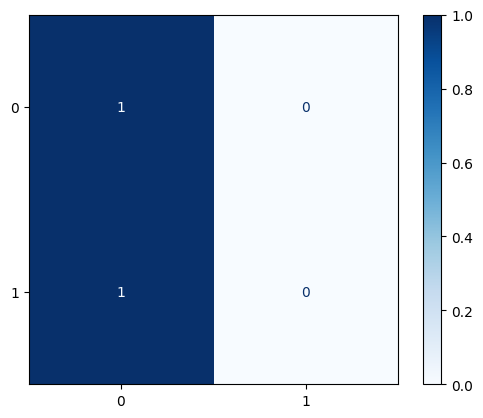

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))

# Display
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


In [56]:
import torch

def predict_language(sentence):
    # Move model and inputs to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input and move tensors to device
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    outputs = model(**inputs)

    # Apply softmax and find the predicted label
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred_label = torch.argmax(predictions, dim=1).item()
    return list(label_mapping.keys())[list(label_mapping.values()).index(pred_label)]


In [62]:
# Test prediction
print(predict_language("Where is the ball"))

italian


In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming `true_labels` and `predicted_labels` are lists of true and predicted labels, respectively
# And `label_mapping` is a dictionary that maps language names to numeric labels

# Invert the label_mapping to get a list of language names by their index order
label_names = [label for label, _ in sorted(label_mapping.items(), key=lambda item: item[1])]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')

# Show plot
plt.show()


NameError: name 'true_labels' is not defined

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

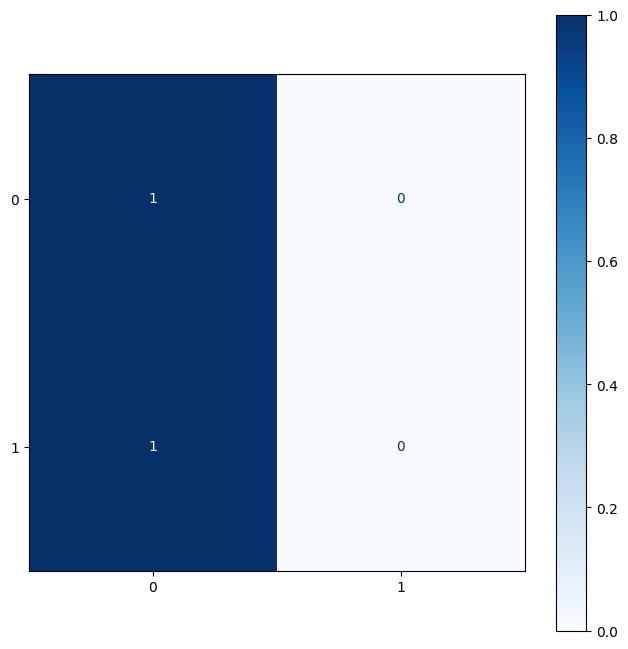

In [65]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions and collect true labels
true_labels = []
predicted_labels = []

# Switch model to evaluation mode
model.eval()

# Iterate over test dataset
for item in test_dataset:
    # Get input IDs and attention mask
    inputs = {key: item[key].unsqueeze(0) for key in ['input_ids', 'attention_mask']}

    # Get true label
    true_labels.append(item['labels'].item())

    # Get model prediction
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred_label = torch.argmax(predictions, dim=1).item()
    predicted_labels.append(pred_label)

# Map numeric labels to language names for display
label_names = [label for label, _ in sorted(label_mapping.items(), key=lambda item: item[1])]

# Compute and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')

plt.show()


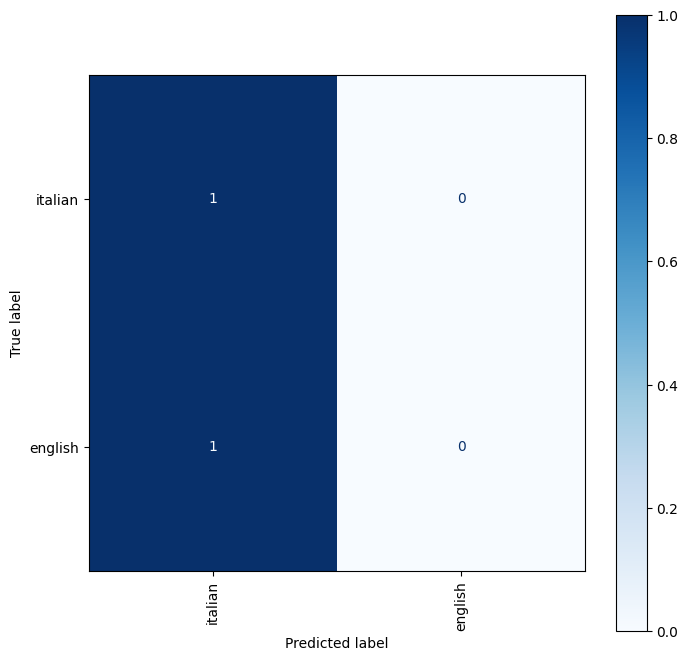

In [66]:
import numpy as np

# Ensure `label_names` matches unique labels in true/predicted labels
unique_labels = np.unique(true_labels + predicted_labels)
label_names = [label for label, idx in sorted(label_mapping.items(), key=lambda item: item[1]) if idx in unique_labels]

# Compute confusion matrix with the correct labels
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')

plt.show()


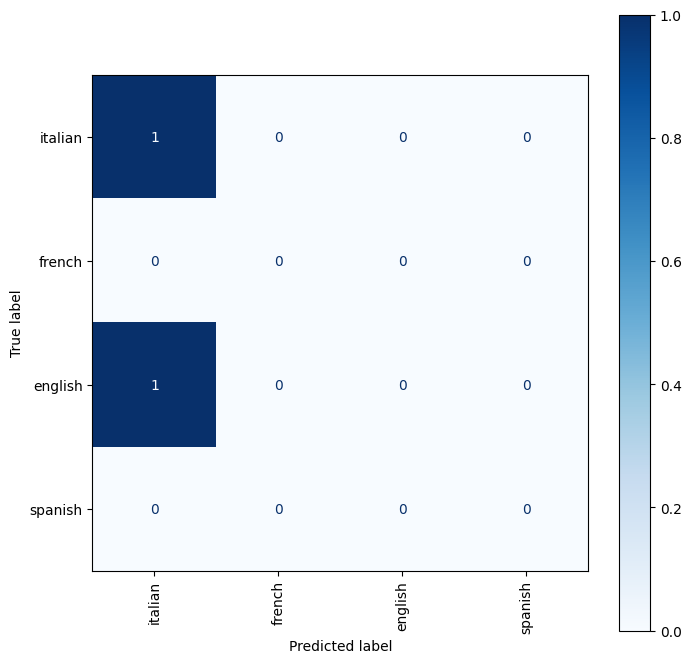

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Define the full set of labels in the order they appear in your model
label_names = list(label_mapping.keys())  # Ensure this includes all 4 languages
all_labels = list(label_mapping.values())  # All numeric labels corresponding to the languages

# Compute the confusion matrix with all labels
cm = confusion_matrix(true_labels, predicted_labels, labels=all_labels)

# Plot confusion matrix with all labels
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')

plt.show()
